<div class="alert alert-block alert-success">
    <b>ARTIFICIAL INTELLIGENCE (E016350B)</b> <br>
ALEKSANDRA PIZURICA <br>
GHENT UNIVERSITY <br>
AY 2023/2024 <br>
Assistant: Nicolas Vercheval
</div>

# Autoencoders

Autoencoders are a type of neural network trained to learn the identity function. In other words, they try to learn the function $f(x)=x$, i.e., to reconstruct their input $x$. Such a network consists of an `encoder` and a `decoder`.

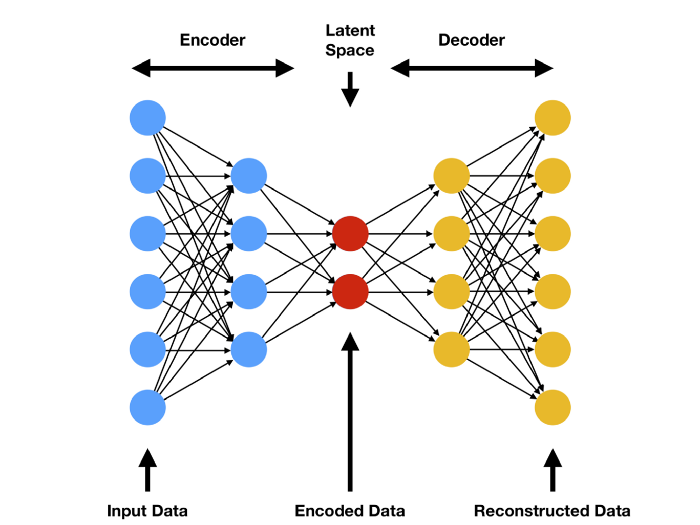

The `encoder` compresses the input of dimension $A$ into a vector of dimension $B<A$, i.e., it reduces the dimensionality. The vector of dimension $B$ is called a code (latent representation).

The `decoder` recovers a vector with the initial dimension dimension $A$ from the obtained code, i.e., it reconstructs the input based on the latent representation.

Autoencoder training is a form of unsupervised learning which can be later applied to classification and regression problems. Another application is dimensionality reduction (for example, in Natural Language Processing (NLP), the famous `GloVe` and `Word2Vec` representations are obtained through specific autoencoders).

The following example, however, shows a slightly different scenario by applying a **Denoising Autoencoder** to an image processing task.

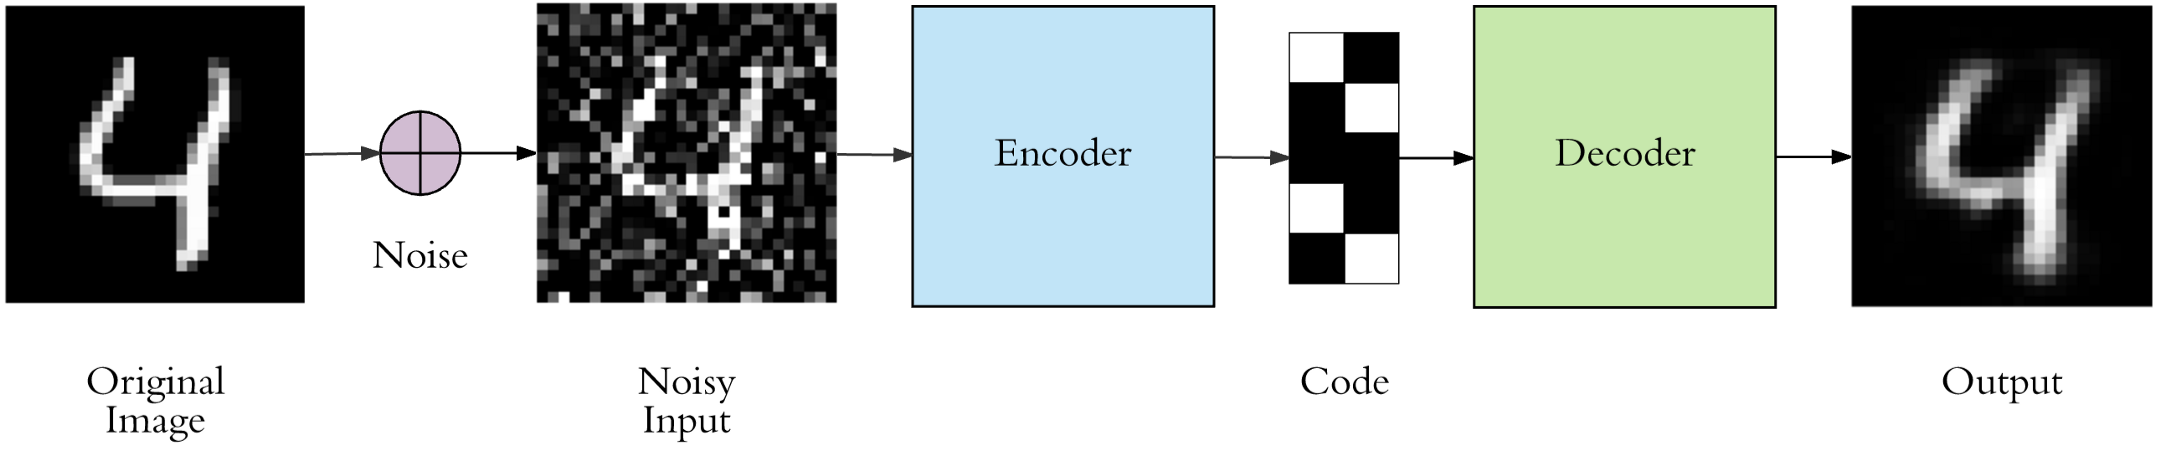

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
np.random.seed(1337)

First we will load the dataset. The labels themselves that are associated with the instances are not important for autoencoders.

In [ ]:
(X_train, _), (X_test, _) = mnist.load_data()

The images we work with are of size $28\times 28$, and we will prepare them by correcting them and normalizing their values. In addition, we will add an additional dimension to the images with a value of $1$ representing their channel (the images are black and white).

In [ ]:
image_size = X_train.shape[1]
print(image_size)

In [ ]:
X_train = np.reshape(X_train, (-1, image_size, image_size, 1))
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, (-1, image_size, image_size, 1))
X_test = X_test.astype('float32') / 255

In [ ]:
X_train.shape

In [ ]:
X_test.shape

Next, we will generate noise from the normal $\mathcal{N}(0.5,0.5)$ distribution, which will be added to the images.

In [ ]:
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

# We will cut off the values that fell out of the range [0,1] after adding the noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

We will show, for example, 9 modified images obtained this way.

In [ ]:
nrows = 3
ncols = 3

# We prepare a panel for drawing each of the images
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(13, 12)

# We extract nrows*ncols images at random
ix = np.random.randint(low=0, high=X_train_noisy.shape[0], size=nrows*ncols)
chosen_imgs = X_train_noisy[ix]

# We plot each image separately
i = 0
for row in ax:
    for col in row:
        # Before displaying them we change the dimension of each image from (image_size,image_size,1)
        # to (image_size, image_size) as this is required by matplotlib
        img = chosen_imgs[i].reshape(image_size, image_size)
        col.imshow(img, cmap='gray')
        col.axis('off')
        i += 1
        
plt.show()       

Next, we will define the network parameters. The input to the network is a tensor of the form $(28, 28, 1)$ where $28\times 28$ is the dimension of the image, and $1$ indicates that there is only one channel because the images are black and white. We will map those images to vectors of dimension $16$.

In [ ]:
input_shape = (image_size, image_size, 1)
latent_dim = 16

## Encoder

The encoder will be a convolutional network that maps the tensors of dimension $(28, 28, 1)$ into a vector of dimension $16$.

In [ ]:
# Kernel size
kernel_size = 3

# Number of filters in convolutional layers
layer_filters = [32, 64]

We will use the functional API of the Keras library to create the network.

In [ ]:
# We have the input layer
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Afterwards we have two convolutional layers
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# We will read and preserve the dimensions of the tensor to obtain
# (None, 7, 7, 64) 
shape = K.int_shape(x)

# Then we have a flattening layer
x = Flatten()(x)

# and then the dense layer that generates the latent representation
latent_outputs = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs=inputs, outputs=latent_outputs, name='encoder')
encoder.summary()

## Decoder

The decoder will be a convolutional neural network that maps a vector of dimension $16$ into a tensor of dimension $(28,28,1)$.

In [ ]:
# Kernel size
kernel_size = 3

# Number of filters in convolutional layers
layer_filters = [32, 64]

In [ ]:
# First we have the input layer
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# afterwards we have one dense layer that allows us to 
# transform the input into (None, 7, 7, 64)
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# then we add transposed convolutional layers but in a reversed order compared to the encoder
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                    kernel_size=kernel_size,
                    strides=2,
                    activation='relu',
                    padding='same')(x)

# then we add one more convolutional layer to control the channel dimension   
x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

# and one activation later with the sigmoid activation function
outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')
decoder.summary(line_length=110)

Next, we use the constructed models to make an autoencoder.

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')

Next, we train the autoencoder. The autoencoder receives as inputs the noised image and as outputs the original images. That way, the autoencoder will learn how to remove the noise, i.e., to reconstruct the images.

In [ ]:
batch_size = 128
epochs = 1

We set the number of epochs equal to $10$ because it may take up to one minute per epoch.

In [ ]:
autoencoder.fit(X_train_noisy,
                X_train,
                validation_data=(X_test_noisy, X_test),
                epochs=epochs,
                batch_size=batch_size)

The result of the previous training can be saved within the `models` directory and can be used instead of the trained model.

In [ ]:
autoencoder.save('autoencoder.keras')

In [ ]:
autoencoder = keras.models.load_model("autoencoder.keras")

We will also visually show how the auto-encoder works. We will generate images based on the input images from the test set and then display $300$ of them: in $10$ rows, there will be $30$ images, first original, then with noise, and then those generated by the autoencoder.

In [ ]:
X_decoded = autoencoder.predict(X_test_noisy)

In [ ]:
# We are preparing the panel for plotting the images
plt.figure(figsize=(30, 30))

# We extract 10x30 images
rows, cols = 10, 30
num = rows * cols

# We select the images: first the original ones, then the noisy ones, and then those generated by the autoencoder
imgs = np.concatenate([X_test[:num], X_test_noisy[:num], X_decoded[:num], np.zeros_like(X_test[:num])])
imgs = imgs.reshape((rows * 4, cols, image_size, image_size))

# We organize the images such that they have the described shape
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 4, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.axis('off')
plt.title('Original images: top row. '
          'Noisy images: middle row. '
          'Obtained output: third row.', fontsize = 16)

# We are plotting the images
plt.imshow(imgs, interpolation='none', cmap='gray')

# We store the image generated in this way
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

In [ ]:
dir(autoencoder)